# R-CNN - Aula Prática

## Configuração

Importando módulos necessários

In [ ]:
%load_ext nbproxy

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import tv_tensors
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2 as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np
import glob
import os
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

## Introdução

Neste Notebook vamos utilizar um modelo da família das Regional CNNs (R-CNNs) para detectar rochas em uma área de quebra dessas rochas. ([link para o dataset](https://github.com/epoc88/SecondaryBreakingDataset)) Entre 2014 e 2016 foram propostos três artigo seminais usando como base R-CNNs:

1.   A [R-CNN clássica](https://arxiv.org/pdf/1311.2524.pdf);
2.   A [Fast R-CNN](https://arxiv.org/pdf/1504.08083.pdf);
3.   E a [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf).

Como os nomes indicam, as arquiteturas de detecção foram sendo otimizadas para serem rodadas em tempo real, de modo que pudessem ser usadas em aplicações como carros autônomos. Toda a família das R-CNNs parte de um princípio consideravelmente simples: alimentar subregiões de imagens para uma CNN pré-treinada em um dataset grande e obter uma predição para qual tipo de objeto está naquele patch da imagem. R-CNNs clássicas usavam a CNN apenas como extratora de features, contando com uma seleção de patches feita pelo algoritmo [Selective Search](https://ivi.fnwi.uva.nl/isis/publications/2013/UijlingsIJCV2013/) e uma classificação usando um [SVM](https://link.springer.com/article/10.1007%2FBF00994018) para realizar a inferência da classe do patch. O esquema de uma R-CNN clássica pode ser visto nas imagens abaixo.

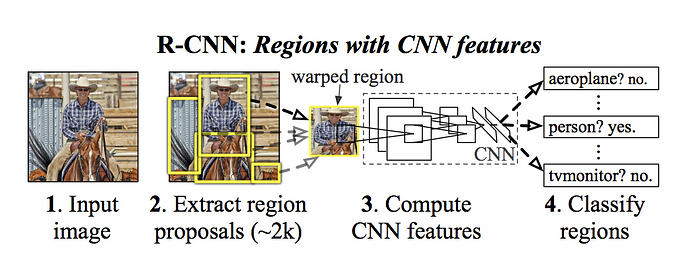

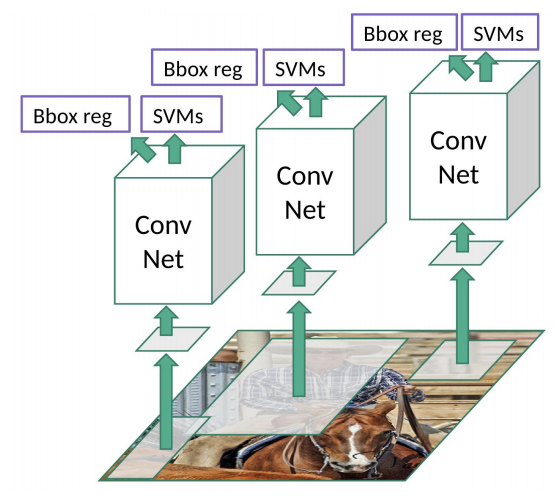

R-CNNs clássicas são altamente limitadas em qualidade de detecção e eficiência por uma série de fatores, incluindo a quantidade enorme de regiões propostas pelo Selective Search (~2000 regiões por imagem, que tinham que ser passadas pela CNN) e a impossiblidade de backpropagar erro de acordo com as predições de classe do SVM que fazia a inferência. Visando mitigar parte desses problemas, a primeira arquitetura que usava a própria CNN para realizar as inferências das classes dos patches foi a Fast R-CNN. A Fast R-CNN permitia uma integração do pipeline de inferência com a extração de features, de forma que a extração poderia ser tunada para as especificações do dataset, ao invés de usar uma CNN pré-treinada sem fine-tuning.

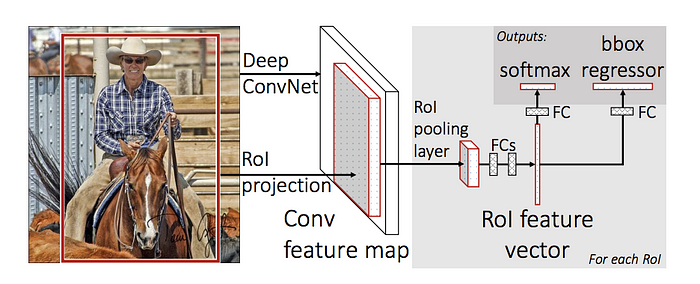

Além de ganhos expressivos em qualidade de detecção as Fast R-CNNs faziam o forward da imagem apenas uma vez pela CNN e selecionavam os patches candidatos usando os feature maps retornados pela CNN, ao invés de passar os ~2000 patches separadamente pela rede como fazia a R-CNN. Isso trouxe ganhos de desempenho de treinamento de aproximadamente uma ordem de magnitude e ganhos no tempo de teste entre uma e duas ordens de magnitude, como pode ser visto na figura abaixo.

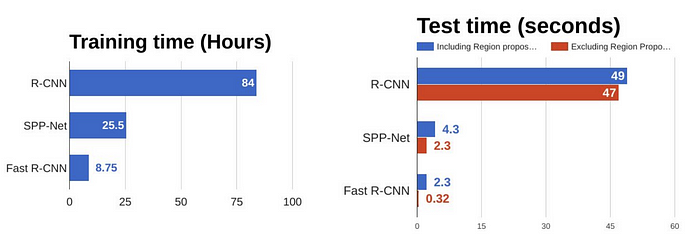

Fast R-CNNs ainda usavam um algoritmo de seleção de regiões não integrado à arquitetura, o que impossibilitava o uso em tempo real dessa arquitetura, já que uma imagem levava aproximadamente 2 segundos para ser processada. O gargalo de eficiência da arquitetura passou, então, a ser o algoritmo de proposição de regiões e não mais os forwards dos patches pela CNN. Pouco tempo depois, as Faster R-CNNs foram propostas por parte do mesmo time de pesquisadores que propôs a R-CNN clássica e a Fast R-CNN, finalmente integrando todo o pipeline de detecção. Além da completa e total falta de criatividade dos pesquisadores para nomear arquiteturas, é notável que as Faster R-CNNs permitem um treinamento end-to-end da arquitetura toda ao incluir uma Region Proposal Network (RPN) para substituir o Selective Search, que era o gargalo da Fast R-CNN. Os gradientes da RPN propagavam para a CNN extratora de features, ajudando no treinamento, bem como se aproveitavam dos gradientes da classificação dos patches. Dessa forma, além do considerável ganho de eficiência, todas as subtarefas do treinamento podiam se ajudar mutuamente.

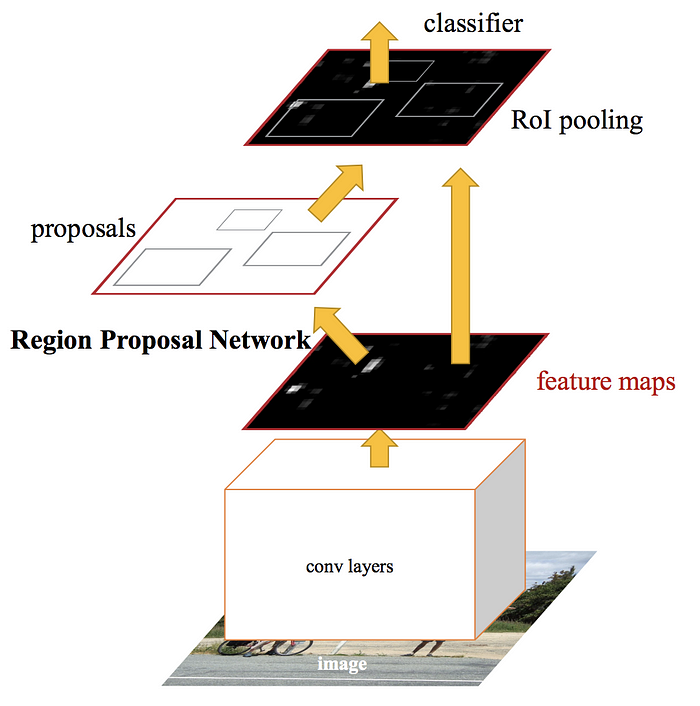

Em 2016, pela primeira vez havia uma arquitetura end-to-end para detecção de objetos que podia ser executada numa escala próxima de em tempo real, já que, mais uma vez, o ganho de eficiência em relação às Fast R-CNNs foi por volta de uma ordem de magnitude. Implementações eficientes de Faster R-CNNs conseguem processar até 5 frames/segundo.

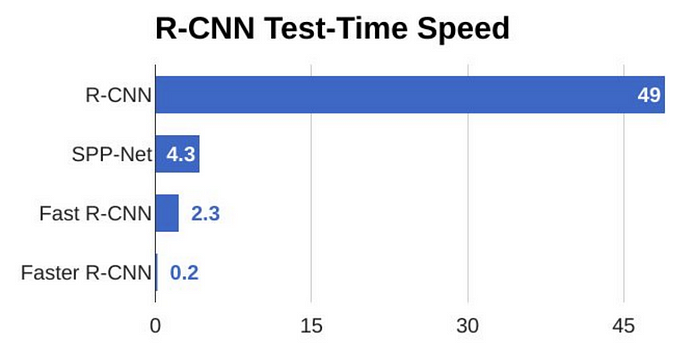

## Dataset

O dataset escolhido para esta tarefa foi proposto em [Autonomous robotic rock breaking using a real-time 3D visual perception system](https://onlinelibrary.wiley.com/doi/full/10.1002/rob.22022) como parte de uma pipeline para detecção e quebra de rochas. Neste notebook vamos focar na tarefa de detecção dessas rochas na imagem. Para isso precisamos inicialmente definir o dataset no formato esperado pelo Torch.

In [2]:
class BreakingDataset(torch.utils.data.Dataset):
    def _get_labels(self, path):
        with open(path) as f:
            lines = [line.rstrip('\n') for line in f]
        
        target_classes = [int(line.split()[0]) + 1 for line in lines] # 0 is for background
        target_boxes = [[float(p) for p in line.split()[1:]] for line in lines]

        return target_classes, target_boxes

    def __init__(self, root, transforms=None, samples=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(glob.glob(os.path.join(root, "*.png"))))
        self.labels = list(sorted(glob.glob(os.path.join(root, "*.txt"))))

        if samples is not None:
            self.imgs = [self.imgs[i] for i in samples]
            self.labels = [self.labels[i] for i in samples]

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        labels_path = self.labels[idx]

        img = read_image(img_path)[0:3, ...]
        labels = self._get_labels(labels_path)

        target = {}
        img_shape = transforms.functional.get_size(img)
        if len(labels[1]) == 0:
            boxes = torch.zeros((0, 4))
        else:
            # TODO: Transforme as coordenadas para o formato XYXY (lembre que elas estão no intervalo [0, 1]
            #                   e tv_tensors.BoundingBoxes espera as coordenadas no intervalo [0, img_shape])
            boxes = ...
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img_shape)
        target["labels"] = torch.tensor(labels[0], dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
def plot_sample(image, boxes, labels, scores, score_threshold=0.5, iou_threshold=0.4, figsize=(9, 6)):
    good_boxes = np.where(scores >= score_threshold)[0]
    boxes = boxes[good_boxes]
    scores = scores[good_boxes]
    labels = [labels[i] for i in good_boxes]

    boxes_nms = torchvision.ops.nms(boxes, scores, iou_threshold=iou_threshold)

    labels = [labels[i] for i in boxes_nms]
    output_image = draw_bounding_boxes(image, boxes[boxes_nms], labels, colors="red")

    plt.figure(figsize=figsize)
    plt.imshow(output_image.permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
dataset_path = '/pgeoprj2/ciag2024/dados/breaking_dataset'

ds = BreakingDataset(
    dataset_path,
)

In [ ]:
sample = ds[0]

image = sample[0]
boxes = sample[1]["boxes"]
labels = ['rock' for _ in sample[1]["labels"]]
scores = torch.ones(len(labels))

plot_sample(image, boxes, labels, scores, iou_threshold=1)

In [ ]:
total_samples = len(ds)
print(total_samples, 'amostras no total')

train_samples = list(range(total_samples))
# TODO: Divida as amostras em treino, validação e teste
train_samples, val_samples = ...
val_samples, test_samples = ...

print('treino, validação, teste:', len(train_samples), len(val_samples), len(test_samples))

In [7]:
# TODO: Crie uma transformação que redimensiona a imagem para 224x224
ds_transform = transforms.Compose(
    ...
)

# TODO: Crie os datasets de treino, validação e teste
train_ds = ...
val_ds = ...
test_ds = ...

In [ ]:
sample = train_ds[0]

image = sample[0]
boxes = sample[1]["boxes"]
labels = ['rock' for _ in sample[1]["labels"]]
scores = torch.ones(len(labels))

plot_sample(image, boxes, labels, scores, iou_threshold=1)

## Modelo

Nós vamos utilizar o modelo já pré-treinado disponível no [PyTorch](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html) para realizar o fine-tuning para nossa tarefa específica. Para isso, vamos carregar o modelo e substituir a camada de classificação para se adequar ao nosso problema. 

In [ ]:
# carrega o modelo pré-treinado
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# TODO: Substitua o classificador por um novo, 
# que tenha num_classes correto para o seu problema
# (lembre que o número de classes é o número de classes + 1, pois a classe 0 é a background)
num_classes = ...

# Obtendo o número de features de entrada do classificador
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Substituindo o classificador
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model)

Ao executar o modelo do pytorch em modo de treino, ele retorna as losses do modelo, vamos utilizar essas losses para realizar o backpropagation e atualizar os pesos do modelo.

In [ ]:
model.train()
model([train_ds[0][0]], [train_ds[0][1]])

Em modo de avaliação, o modelo retorna as predições para as imagens de entrada.

In [ ]:
model.eval()
model([train_ds[0][0]])

In [12]:
# A funcção abaixo é usada para juntar as amostras em um batch. Ela é necessária porque as amostras podem ter tamanhos diferentes.
def collate_fn(batch):
    return tuple(zip(*batch))

# TODO: Crie os dataloaders de treino, validação e teste (lembre de adicionar o collate_fn)
train_dl = ...
val_dl = ...
test_dl = ...

## Treinamento

In [13]:
def loss_to_string(loss, prefix):
    return ' '.join([f'{prefix}_{l}: {loss[l]:.4f}' for l in loss])

def evaluate(model, test_loader, device='cpu'):
    model.to(device)
    model.train() # mantendo treinamento para obter as lossses

    total_losses = {'loss': 0.0}

    with torch.no_grad():
        for i, (inputs, targets) in (pbar := tqdm(enumerate(test_loader), total=len(test_loader), unit='batch')):
            inputs, targets = [i.to(device) for i in inputs], [{tl: t[tl].to(device) for tl in t} for t in targets]

            # TODO: realize o forward pass e calcule as losses
            # lembre que o output do modelo é um dicionário com as losses
            ...

    for l in total_losses:
        total_losses[l] /= len(test_loader)
    
    return total_losses

def train(model, optimizer, train_loader, val_loader=None, device='cpu', epochs=32):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        # Training phase
        epoch_losses = {'train': {'loss': 0.0}, 'val': {'loss': 0.0}}

        for i, (inputs, targets) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs, targets = [i.to(device) for i in inputs], [{tl: t[tl].to(device) for tl in t} for t in targets]

            # TODO: realize o forward pass e o backpropagation (não se esqueça de limpar os gradientes)
            # lembre que o output do modelo é um dicionário com as losses
            ...
        
        for l in epoch_losses['train']:
            epoch_losses['train'][l] /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            epoch_losses['val'] = evaluate(model, val_loader, device=device)
            print(f"Epoch {epoch + 1}/{epochs}: {loss_to_string(epoch_losses['train'], 'train')} | {loss_to_string(epoch_losses['val'], 'val')}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: {loss_to_string(epoch_losses['train'], 'train')}")


In [ ]:
# TODO: Treine o modelo
epochs = 2
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = ...
device = ...
torch.cuda.empty_cache()

train(model, optimizer, train_dl, val_dl, device=device, epochs=epochs)

## Validação

In [ ]:
# TODO: Avalie o modelo no conjunto de teste
test_metrics = ...
print(loss_to_string(test_metrics, 'test'))

In [ ]:
sample = test_ds[0]
model.eval()
preds = model([sample[0].to(device)])

image = sample[0]
boxes = preds[0]["boxes"].cpu()
scores = preds[0]["scores"].cpu()
labels = preds[0]["labels"].cpu()

plot_sample(image, boxes, ['rock' for _ in labels], scores, iou_threshold=0.4)

## Desafio

Treine o modelo no VOCDetection utilizado no notebook anterior e compare seus resultados com o YOLO.

In [44]:
from torchvision.datasets import VOCDetection